# Look at paths that were within DrugMechDB

Here we will look at the DrugMechDB paths contained within the network, and compare them to the actual paths selected by the model.

In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from data_tools import df_processing as dfp

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
load_dir = Path('../2_pipeline').resolve()
model_name = '15_Final_Model_Training'

nw_dir = load_dir.joinpath('12d_Preprocessing-Abbreviations_and_Biolink', 'out')
hyp_dir = load_dir.joinpath('13c_Model_Prep_Hyperparam_tuning', 'out')
model_dir = load_dir.joinpath(model_name, 'out')
paths_dir = load_dir.joinpath('16b_Model_results_analysis_DMDB', 'out')

In [3]:
p_a_dir = load_dir.joinpath('MOA_Analysis', 'out')

In [4]:
this_name = '17_Target_Analysis'
out_dir = load_dir.joinpath(this_name, 'out')

out_dir.mkdir(exist_ok=True, parents=True)


In [5]:
nodes = pd.read_csv(nw_dir.joinpath('nodes_biolink.csv'), dtype=str)
edges = pd.read_csv(nw_dir.joinpath('edges_biolink.csv'), dtype=str)

In [6]:
best_param = pickle.load(open(hyp_dir.joinpath('best_param.pkl'), 'rb'))

In [7]:
from hetnet_ml.extractor import MatrixFormattedGraph
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=best_param['w'], n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:59<00:00,  1.15it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:27<00:00,  2.44it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 113.66it/s]


In [8]:
model = pickle.load(open(model_dir.joinpath('model.pkl'), 'rb'))

In [9]:
coef = pd.read_csv(model_dir.joinpath('coef.csv'))
metapaths = coef.query('feature != "intercept"')['feature'].tolist()

In [10]:
from data_tools.graphs import dataframes_to_metagraph, metapaths_to_json
metagraph = dataframes_to_metagraph(nodes, edges)

all_metapaths = metagraph.extract_metapaths('ChemicalSubstance', 'Disease', 4)
mp_info = {mp.abbrev: mp for mp in all_metapaths if mp.abbrev in metapaths}

In [11]:
res = pd.read_csv(model_dir.joinpath('results.csv'))
len(res)

90996724

In [12]:
id_to_name = nodes.set_index('id')['name'].to_dict()
id_to_label = nodes.set_index('id')['label'].to_dict()

res['chem_name'] = res['chemicalsubstance_id'].map(id_to_name)
res['dis_name'] = res['disease_id'].map(id_to_name)
res = res.sort_values('proba', ascending=False).reset_index(drop=True)

res.head(2)

,chemicalsubstance_id,disease_id,status,proba,chem_name,dis_name
0,CHEBI:53769,MONDO:0005399,0,0.997371,(S)-acenocoumarol,venous thromboembolism
1,CHEBI:50438,MONDO:0005399,0,0.997320,phenprocoumon,venous thromboembolism


In [13]:
def find_nodes_by_name(sub_str, n_type=None):
    if n_type is not None:
        qr = nodes.query('label == @n_type')   
    else:
        qr = nodes
    
    return qr[qr['name'].str.contains(sub_str)]

In [14]:
pos_coef = coef.query('coef > 0')['feature'].tolist()

In [15]:
msat = model[0]
max_abs = model[1]

In [16]:
ini_means = {f: m for f, m in zip(metapaths, msat.initial_mean_)}
ma_scale = {f: m for f, m in zip(metapaths, max_abs.scale_)}
feat_coef = coef.set_index('feature')['coef'].to_dict()
feat_zcoef = coef.set_index('feature')['zcoef'].to_dict()

In [17]:
def get_model_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_coef) * percent_of_total
    return model_metric

In [18]:
def get_std_model_metric(path_df):
    
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metric'] / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    model_metric = scal_metric * path_df['metapath'].map(feat_zcoef) * percent_of_total
    return model_metric

In [19]:
def get_scal_dwpc_metric(path_df):
    totals = path_df.groupby('metapath')['metric'].sum().to_dict()
    percent_of_total = path_df['metric'] / path_df['metapath'].map(totals)
    
    trans_metric = np.arcsinh(path_df['metapath'].map(totals) / path_df['metapath'].map(ini_means))
    scal_metric = trans_metric / path_df['metapath'].map(ma_scale)
    
    dwpc_metric = scal_metric * percent_of_total
    return dwpc_metric

In [20]:
def get_path_info(compound, disease, n_jobs=30, mps=None):
    if mps == None:
        mps = pos_coef
    
    path_df = pd.DataFrame(mg.extract_paths(compound, disease, mps, n_jobs=n_jobs))
    if len(path_df) == 0:
        return float('nan')
    
    path_df['model_metric'] = get_model_metric(path_df)
    path_df['std_metric'] = get_std_model_metric(path_df)
    path_df['scal_metric'] = get_scal_dwpc_metric(path_df)
    
    return path_df

## Load in the DrugMechDB Paths

In [21]:
dmdb_paths = pd.read_csv(p_a_dir.joinpath('mapped_vs_missing.csv'))
clean_paths = []
chem_ids = []
dis_ids = []
path_pairs = []

for row in dmdb_paths.itertuples(index=False):
    skip = False
    prev = row[0]   
    for n in row:
        if n == "missing":
            skip = True
            break
        elif pd.isnull(n):
            break
        if not skip:
            prev = n
        
    if not skip:
        chem_ids.append(row[0])
        dis_ids.append(prev)
        path_pairs.append((row[0], prev))
        clean_paths.append(row)
dmdb_paths = pd.DataFrame(clean_paths).drop_duplicates()

In [22]:
feature_order = pd.read_csv(model_dir.joinpath('feature_order.txt'), header=None)[0].tolist()

In [23]:
chem_to_extract = list(set(chem_ids))

In [24]:
# Some "Diseases" may be phenotypes, so we should enforce diseaes for extraction
dis_to_extract = list(set(nodes.query('label == "Disease"')['id']) & set(dis_ids))

In [25]:
(dmdb_pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=feature_order, start_nodes=chem_to_extract, 
                                        end_nodes=dis_to_extract, n_jobs=30, return_sparse=True, sparse_df=False)

Preparing function arguments...
Calculating DWPCs...


100%|██████████| 156/156 [02:56<00:00,  1.13s/it]



Reshaping Result Matrices...


100%|██████████| 156/156 [00:00<00:00, 892.00it/s]

Stacking columns...


In [26]:
dmdb_pairs['proba'] = model.predict_proba(dwpc)[:, 1]

In [27]:
dmdb_pairs['chem_name'] = dmdb_pairs['chemicalsubstance_id'].map(id_to_name)
dmdb_pairs['dis_name'] = dmdb_pairs['disease_id'].map(id_to_name)

In [28]:
pos_tups = set(edges.query('type == "treats_CtD"')[['start_id', 'end_id']].apply(tuple, axis=1))

In [29]:
status = []
for row in dmdb_pairs.itertuples():
    tup = (row.chemicalsubstance_id, row.disease_id)
    status.append(int(bool(pos_tups & {tup})))

In [30]:
dmdb_pairs['status'] = status
dmdb_pairs.sample(10)

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status
623,CHEBI:31583,DOID:10763,0.035005,Etizolam,hypertension,0
898,CHEBI:34923,DOID:2457,0.005413,Pinacidil,giant papillary conjunctivitis,0
1418,CHEBI:6538,DOID:11335,0.003510,Loratadine,sarcoidosis,0
186,CHEBI:135990,DOID:11335,0.004225,gepirone,sarcoidosis,0
1928,CHEBI:9667,DOID:8552,0.037567,triamcinolone,chronic myeloid leukemia,0
1263,CHEBI:53769,DOID:60164,0.086744,(S)-acenocoumarol,Pain relief,0
283,CHEBI:15443,DOID:2474,0.005413,inulin,vernal conjunctivitis,0
317,CHEBI:15640,DOID:11204,0.003493,5-formyltetrahydrofolic acid,allergic conjunctivitis,0
741,CHEBI:31690,DOID:8577,0.067364,imatinib methanesulfonate,ulcerative colitis,0
748,CHEBI:31759,DOID:0050425,0.007875,Lafutidine,restless legs syndrome,0


In [31]:
dmdb_pairs = dmdb_pairs.sort_values('proba', ascending=False)

In [32]:
dmdb_pairs['tup'] = dmdb_pairs[['chemicalsubstance_id', 'disease_id']].apply(tuple, axis=1)

In [33]:
dmdb_pairs.query('tup in @path_pairs')

,chemicalsubstance_id,disease_id,proba,chem_name,dis_name,status,tup
1274,CHEBI:53769,DOID:9477,0.988792,(S)-acenocoumarol,pulmonary embolism,0,"(CHEBI:53769, DOID:9477)"
42,CHEBI:10033,DOID:9477,0.950225,warfarin,pulmonary embolism,1,"(CHEBI:10033, DOID:9477)"
1459,CHEBI:6942,DOID:10763,0.924148,minoxidil,hypertension,1,"(CHEBI:6942, DOID:10763)"
1570,CHEBI:75725,DOID:60145,0.629704,"(R,R)-tramadol",Pain,1,"(CHEBI:75725, DOID:60145)"
1571,CHEBI:75725,DOID:60164,0.603647,"(R,R)-tramadol",Pain relief,1,"(CHEBI:75725, DOID:60164)"
321,CHEBI:15640,DOID:13382,0.578812,5-formyltetrahydrofolic acid,megaloblastic anemia,0,"(CHEBI:15640, DOID:13382)"
938,CHEBI:36797,DOID:1470,0.577926,(R)-duloxetine,major depressive disorder,1,"(CHEBI:36797, DOID:1470)"
740,CHEBI:31690,DOID:8552,0.343985,imatinib methanesulfonate,chronic myeloid leukemia,1,"(CHEBI:31690, DOID:8552)"
887,CHEBI:34923,DOID:10763,0.332814,Pinacidil,hypertension,1,"(CHEBI:34923, DOID:10763)"
825,CHEBI:32193,DOID:6432,0.287274,Terguride,pulmonary hypertension,0,"(CHEBI:32193, DOID:6432)"


In [33]:
def get_pair_idx(idx, df):

    cid = df.loc[idx, 'chemicalsubstance_id']
    did = df.loc[idx, 'disease_id']
    prob = df.loc[idx, 'proba']

    print('Extracting data for: {} -TREATS- {}'.format(id_to_name[cid], id_to_name[did]))
    try:
        path_df = get_path_info(cid, did, 30)
    except:
        path_df = get_path_info(cid, did, 1)
    return path_df.sort_values('model_metric', ascending=False).reset_index(drop=True)

In [34]:
from tqdm import tqdm

## Extract all paths for indications in DrugMechDB

In [36]:
dmdb_res = dmdb_pairs.query('tup in @path_pairs')

path_res = dict()


for f in paths_dir.iterdir():
    if f.name.startswith('paths_') and "CHEBI:29081" not in f.name:
        
        test_path = pd.read_csv(f, converters={'nodes': eval, 'node_ids': eval, 'node_id_tup': eval})
        start_id = f.name.split('_')[1]
        end_id = f.name.split('_')[2].rstrip('.csv')
    
        path_res[(start_id, end_id)] = test_path

# Don't do this extraction on future runs...
if len(path_res) == 0:
    # Extract the paths
    for row in tqdm(dmdb_res.itertuples(), total=len(dmdb_res)):
        path_res[row.tup] = get_pair_idx(row.Index, dmdb_res)
        
    # Save so it never needs to be done again...
    for k, v in path_res.items():
        v.to_csv(paths_dir.joinpath('paths_{0}_{1}.csv'.format(*k)), index=False)

In [37]:
from collections import defaultdict

In [38]:
def query_target(path_df, tgt_id):
    tgt_ids = path_df['node_ids'].apply(lambda x: x[1])
    
    idx = tgt_ids == tgt_id
    idx = idx[idx].index
    
    return path_df.loc[idx]

In [71]:
for k, v in path_res.items():
    print(k, id_to_name[k[0]])

('CHEBI:4637', 'DOID:9060') diphenhydramine hydrochloride
('CHEBI:64354', 'DOID:10763') metolazone
('CHEBI:31690', 'DOID:4660') imatinib methanesulfonate
('CHEBI:31663', 'DOID:37') Halcinonide
('CHEBI:53769', 'DOID:9477') (S)-acenocoumarol
('CHEBI:77733', 'DOID:1307') 2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyphenyl)ethyl](methyl)amino\}-2-(propan-2-yl)pentanenitrile
('CHEBI:9667', 'DOID:0060192') triamcinolone
('CHEBI:15443', 'DOID:4195') inulin
('CHEBI:3398', 'DOID:2457') carbinoxamine
('CHEBI:74789', 'DOID:9060') 9-aminoacridine
('CHEBI:6538', 'DOID:4481') Loratadine
('CHEBI:84115', 'DOID:4730') antazoline
('CHEBI:6538', 'DOID:1205') Loratadine
('IKEY:HJBWBFZLDZWPHF-UHFFFAOYSA-N', 'DOID:10283') ARN509
('CHEBI:4463', 'DOID:70004') Dexamethasone acetate
('CHEBI:51380', 'DOID:1205') doxylamine
('CHEBI:42797', 'DOID:0050425') gabapentin
('CHEBI:5134', 'DOID:6132') fluticasone
('CHEBI:58987', 'DOID:1875') sildenafil citrate
('CHEBI:31759', 'DOID:8534') Lafutidine
('CHEBI:15640', 'DOID

In [40]:
def group_tgt_metric(path_df, id_to_name=None):
    
    # Pull the target out of the path
    path_df['tgt'] = path_df['node_ids'].apply(lambda x: x[1])
    
    # Group on target and provide sum
    tgt_res = path_df.groupby('tgt')[['metric', 'model_metric', 'std_metric']].sum()
                                     
    tgt_res = tgt_res.sort_values('model_metric', ascending=False)
    tgt_res = tgt_res.reset_index()

    # Map names for the targets
    if id_to_name is not None:
        tgt_res['tgt_name'] = tgt_res['tgt'].map(id_to_name)
        
    return tgt_res

In [41]:
def quick_key(key):
    print('Compound: {}'.format(id_to_name[key[0]]))
    print('Disease: {}'.format(id_to_name[key[1]]))
    
    idx = path_pairs.index(key)
    tgt = dmdb_paths.loc[idx, 'n2']
    print('Target: {}'.format(id_to_name[tgt]))
    
    tgt_metric = group_tgt_metric(path_res[key], id_to_name)
    
    qr = tgt_metric.query('tgt == @tgt')
    rank = None
    if len(qr != 0):
        rank = qr.index.tolist()[0] + 1
        print('Rank: {}'.format(rank))
    print('Total Targets: {:,}'.format(len(tgt_metric)))
    
    head_n = 10
    if rank is not None and rank > 10:
        head_n = rank
    
    return(tgt_metric.head(head_n))

In [42]:
quick_key(('CHEBI:31690', 'DOID:349'))

Compound: imatinib methanesulfonate
Disease: systemic mastocytosis
Target: KIT
Rank: 1
Total Targets: 540


,tgt,metric,model_metric,std_metric,tgt_name
0,NCBIGene:3815,0.001846,2.202319,0.092466,KIT
1,GO:0006919,0.000023,0.704976,0.040549,activation of cysteine-type endopeptidase acti...
2,GO:0042307,0.000017,0.588388,0.031953,positive regulation of protein import into nuc...
3,GO:0006754,0.000011,0.424579,0.020574,ATP biosynthetic process
4,GO:0036119,0.000007,0.318544,0.024390,response to platelet-derived growth factor
5,GO:0007049,0.000009,0.299229,0.012528,cell cycle
6,NCBIGene:3315,0.000018,0.285477,0.020538,HSPB1
7,GO:0051881,0.000014,0.266722,0.011381,regulation of mitochondrial membrane potential
8,NCBIGene:3162,0.000082,0.240648,0.008664,HMOX1
9,GO:0008284,0.000006,0.210084,0.008300,positive regulation of cell proliferation


In [43]:
quick_key(('CHEBI:31690', 'DOID:8552'))

Compound: imatinib methanesulfonate
Disease: chronic myeloid leukemia
Target: ABL1
Rank: 5
Total Targets: 540


,tgt,metric,model_metric,std_metric,tgt_name
0,GO:0036119,0.000070,1.189846,0.077802,response to platelet-derived growth factor
1,NCBIGene:613,0.002694,1.087702,0.044466,BCR
2,GO:0004743,0.000076,0.557325,0.030545,pyruvate kinase activity
3,GO:0070640,0.000040,0.533069,0.030391,vitamin D3 metabolic process
4,NCBIGene:25,0.000358,0.529173,0.014843,ABL1
5,GO:0014827,0.000041,0.445304,0.023776,intestine smooth muscle contraction
6,GO:0043306,0.000051,0.407233,0.018964,positive regulation of mast cell degranulation
7,GO:0061909,0.000037,0.401104,0.020995,autophagosome-lysosome fusion
8,NCBIGene:6850,0.000062,0.398241,0.013484,SYK
9,NCBIGene:1432,0.000934,0.395320,0.011856,MAPK14


In [44]:
quick_key(('CHEBI:64354', 'DOID:10763'))

Compound: metolazone
Disease: hypertension
Target: SLC12A3
Rank: 1
Total Targets: 8


,tgt,metric,model_metric,std_metric,tgt_name
0,NCBIGene:6559,0.003461,4.219810,0.233130,SLC12A3
1,GO:0008217,0.000024,2.981215,0.183347,regulation of blood pressure
2,NCBIGene:1576,0.000056,2.592194,0.160032,CYP3A4
3,NCBIGene:3120,0.000048,0.726211,0.023528,HLA-DQB2
4,NCBIGene:3106,0.000032,0.713829,0.027925,HLA-B
5,NCBIGene:8856,0.000017,0.674804,0.018408,NR1I2
6,REACT:R-HSA-877300,0.000006,0.057768,0.001481,Interferon gamma signaling
7,REACT:R-HSA-913531,0.000005,0.039617,0.000633,Interferon Signaling


In [45]:
quick_key(('CHEBI:58987', 'DOID:1875'))

Compound: sildenafil citrate
Disease: impotence
Target: PDE5A
Rank: 19
Total Targets: 235


,tgt,metric,model_metric,std_metric,tgt_name
0,GO:0060406,0.000172,1.433705,0.101135,positive regulation of penile erection
1,GO:1905395,0.000235,1.312291,0.084471,response to flavonoid
2,GO:0061370,0.000056,1.290910,0.027564,testosterone biosynthetic process
3,NCBIGene:4846,0.000805,1.248626,0.042086,NOS3
4,NCBIGene:598,0.000552,0.886223,0.033638,BCL2L1
5,GO:0006941,0.000122,0.821508,0.048318,striated muscle contraction
6,NCBIGene:1906,0.000123,0.786340,0.037428,EDN1
7,NCBIGene:3972,0.000018,0.562241,0.013896,LHB
8,NCBIGene:4842,0.000120,0.554308,0.017595,NOS1
9,NCBIGene:596,0.000202,0.392939,0.010019,BCL2


In [49]:
quick_key(('CHEBI:32193', 'DOID:6432'))

Compound: Terguride
Disease: pulmonary hypertension
Target: HTR2B
Rank: 1
Total Targets: 21


,tgt,metric,model_metric,std_metric,tgt_name
0,NCBIGene:3357,0.001306,2.178963,0.094045,HTR2B
1,NCBIGene:150,0.000079,1.173826,0.043797,ADRA2A
2,NCBIGene:148,0.000181,1.001513,0.025364,ADRA1A
3,NCBIGene:152,0.000095,0.981108,0.022567,ADRA2C
4,NCBIGene:153,0.000091,0.838673,0.020756,ADRB1
5,NCBIGene:154,0.000080,0.698241,0.017876,ADRB2
6,NCBIGene:151,0.000051,0.648060,0.015742,ADRA2B
7,NCBIGene:1815,0.000032,0.603263,0.014904,DRD4
8,NCBIGene:3358,0.000063,0.570087,0.016422,HTR2C
9,NCBIGene:1816,0.000018,0.448719,0.011741,DRD5


In [51]:
quick_key(('CHEBI:31583', 'DOID:2030'))

Compound: Etizolam
Disease: anxiety disorder
Target: GABRA1
Rank: 5
Total Targets: 22


,tgt,metric,model_metric,std_metric,tgt_name
0,NCBIGene:2558,0.000367,2.050776,0.083332,GABRA5
1,NCBIGene:2555,0.000718,1.963583,0.087759,GABRA2
2,NCBIGene:2566,0.000195,1.483145,0.054913,GABRG2
3,NCBIGene:2556,0.000086,1.115466,0.038480,GABRA3
4,NCBIGene:2554,0.000083,1.084854,0.039695,GABRA1
5,NCBIGene:5724,0.000054,0.637106,0.017371,PTAFR
6,NCBIGene:2562,0.000032,0.555010,0.019375,GABRB3
7,NCBIGene:2561,0.000030,0.473877,0.016553,GABRB2
8,REACT:R-HSA-977441,0.000028,0.051036,0.003019,GABA A receptor activation
9,REACT:R-HSA-975298,0.000020,0.035210,0.001789,Ligand-gated ion channel transport


In [52]:
quick_key(('CHEBI:5439', 'DOID:50433'))

Compound: Glutethimide
Disease: Insomnia
Target: GABRA1
Rank: 11
Total Targets: 99


,tgt,metric,model_metric,std_metric,tgt_name
0,GO:0070989,0.000102,3.553854,0.251228,oxidative demethylation
1,NCBIGene:2562,0.000760,1.231304,0.060560,GABRB3
2,GO:0006779,0.000003,0.799159,0.048210,porphyrin-containing compound biosynthetic pro...
3,NCBIGene:2558,0.000071,0.611534,0.022067,GABRA5
4,NCBIGene:2561,0.000056,0.509612,0.024519,GABRB2
5,NCBIGene:2557,0.000072,0.437978,0.013850,GABRA4
6,NCBIGene:2567,0.000074,0.437335,0.013892,GABRG3
7,NCBIGene:2559,0.000073,0.406406,0.012702,GABRA6
8,NCBIGene:2556,0.000068,0.393265,0.012059,GABRA3
9,NCBIGene:2555,0.000070,0.378911,0.011566,GABRA2


In [54]:
quick_key(('CHEBI:75725', 'DOID:60164'))

Compound: (R,R)-tramadol
Disease: Pain relief
Target: OPRM1
Rank: 14
Total Targets: 73


,tgt,metric,model_metric,std_metric,tgt_name
0,NCBIGene:1565,0.000074,1.583751,0.074927,CYP2D6
1,NCBIGene:5173,0.000706,1.580413,0.054605,PDYN
2,NCBIGene:590,0.000070,1.045619,0.038608,BCHE
3,GO:0032769,0.000091,1.008425,0.057464,negative regulation of monooxygenase activity
4,GO:0051350,0.000083,0.907668,0.051088,negative regulation of lyase activity
5,NCBIGene:3358,0.000292,0.794061,0.024994,HTR2C
6,NCBIGene:1814,0.000164,0.631738,0.017308,DRD3
7,GO:0042415,0.000032,0.619811,0.032355,norepinephrine metabolic process
8,NCBIGene:4986,0.000119,0.485671,0.015469,OPRK1
9,NCBIGene:1586,0.000118,0.484165,0.012984,CYP17A1


## Summarize the findings

In [80]:
summary = defaultdict(list)


for key, v in path_res.items():

    summary['comp_id'].append(key[0])
    summary['dis_id'].append(key[1])
    summary['comp_name'].append(id_to_name[key[0]])
    summary['dis_name'].append(id_to_name[key[1]])
    
    idx = path_pairs.index(key)
    tgt = dmdb_paths.loc[idx, 'n2']
    
    summary['target_id'].append(tgt)
    summary['target_name'].append(id_to_name[tgt])
    
    tgt_metric = group_tgt_metric(v, id_to_name)
    qr = tgt_metric.query('tgt == @tgt')
    rank = None
    if len(qr != 0):
        rank = qr.index.tolist()[0] + 1
        summary['tgt_rank'].append(rank)
    else:
        summary['tgt_rank'].append(float('nan'))
    
    summary['total_tgt'].append(len(tgt_metric))
sum_df = pd.DataFrame(summary)

In [81]:
sum_df['tgt_pctile'] = 1 - (sum_df['tgt_rank'] / sum_df['total_tgt'])

In [82]:
sum_df

,comp_id,dis_id,comp_name,dis_name,target_id,target_name,tgt_rank,total_tgt,tgt_pctile
0,CHEBI:4637,DOID:9060,diphenhydramine hydrochloride,pityriasis versicolor,DOID:9060,pityriasis versicolor,NaN,9,NaN
1,CHEBI:64354,DOID:10763,metolazone,hypertension,NCBIGene:6559,SLC12A3,1.0,8,0.875000
2,CHEBI:31690,DOID:4660,imatinib methanesulfonate,indolent systemic mastocytosis,NCBIGene:3815,KIT,NaN,2,NaN
3,CHEBI:31663,DOID:37,Halcinonide,skin disease,GO:0006954,inflammatory response,NaN,2,NaN
4,CHEBI:53769,DOID:9477,(S)-acenocoumarol,pulmonary embolism,NCBIGene:79001,VKORC1,1.0,45,0.977778
5,CHEBI:77733,DOID:1307,"2-(3,4-dimethoxyphenyl)-5-\{[2-(3,4-dimethoxyp...",dementia,NCBIGene:5136,PDE1A,100.0,339,0.705015
6,CHEBI:9667,DOID:0060192,triamcinolone,Crohn's colitis,NCBIGene:2908,NR3C1,4.0,127,0.968504
7,CHEBI:15443,DOID:4195,inulin,hyperglycemia,GO:0032099,negative regulation of appetite,NaN,25,NaN
8,CHEBI:3398,DOID:2457,carbinoxamine,giant papillary conjunctivitis,NCBIGene:3269,HRH1,NaN,1,NaN
9,CHEBI:74789,DOID:9060,9-aminoacridine,pityriasis versicolor,DOID:9060,pityriasis versicolor,NaN,6,NaN


In [83]:
import seaborn as sns

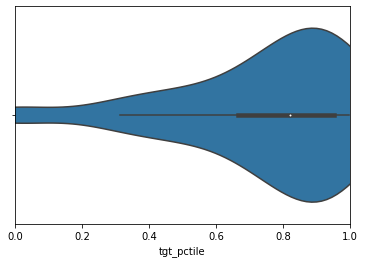

In [84]:
sns.violinplot(sum_df['tgt_pctile'])
plt.xlim([0,1]);

In [85]:
import pandas as pd

In [86]:
mapped_dmdb = pd.read_csv(p_a_dir.joinpath('mapped_vs_missing.csv'))
mapped_dmdb.head(2)

,n1,n2,n3,n4,n5,n6,n7,n8
0,CHEBI:31690,NCBIGene:25,DOID:8552,NaN,NaN,NaN,NaN,NaN
1,CHEBI:31690,NCBIGene:3815,GO:0008283,DOID:4798,NaN,NaN,NaN,NaN


In [87]:
comps = []
diseases = []

for row in mapped_dmdb.itertuples():
    comp = row.n1
    dis = float('nan')
    for x in row:
        if not pd.isnull(x):
            dis = x
            
    comps.append(comp)
    diseases.append(dis)
    
mapped_dmdb['comp_id'] = comps
mapped_dmdb['dis_id'] = diseases

In [88]:
mapped_dmdb.query('comp_id != "missing" and dis_id != "missing"')

,n1,n2,n3,n4,n5,n6,n7,n8,comp_id,dis_id
0,CHEBI:31690,NCBIGene:25,DOID:8552,NaN,NaN,NaN,NaN,NaN,CHEBI:31690,DOID:8552
1,CHEBI:31690,NCBIGene:3815,GO:0008283,DOID:4798,NaN,NaN,NaN,NaN,CHEBI:31690,DOID:4798
2,CHEBI:31690,NCBIGene:3815,GO:0008283,DOID:4660,NaN,NaN,NaN,NaN,CHEBI:31690,DOID:4660
3,CHEBI:31690,NCBIGene:3815,GO:0008283,DOID:349,NaN,NaN,NaN,NaN,CHEBI:31690,DOID:349
4,CHEBI:31690,NCBIGene:5156,GO:0008283,DOID:4798,NaN,NaN,NaN,NaN,CHEBI:31690,DOID:4798
...,...,...,...,...,...,...,...,...,...,...
180,CHEBI:6078,missing,missing,GO:0060081,DOID:80000,missing,DOID:11678,NaN,CHEBI:6078,DOID:11678
184,UNII:7D96IR0PPM,missing,GO:0008283,DOID:9952,NaN,NaN,NaN,NaN,UNII:7D96IR0PPM,DOID:9952
185,CHEBI:135990,NCBIGene:3350,GO:0050795,DOID:1470,NaN,NaN,NaN,NaN,CHEBI:135990,DOID:1470
186,CHEBI:8598,NCBIGene:6530,CHEBI:18357,GO:0023041,DOID:1470,NaN,NaN,NaN,CHEBI:8598,DOID:1470


In [89]:
def rank_connecting_nodes(path_df, metric='model_metric'):
    
    first_path = path_df.iloc[0, 0]
    comp_id = first_path[0]
    dis_id = first_path[-1]
    
    metric_vals = path_df[[metric]].reset_index()
    
    # Expand all the nodes
    all_nodes = dfp.expand_split_col(path_df['node_ids'])
    
    # Add in each metric for each instance of a node
    all_nodes = all_nodes.merge(metric_vals, left_on=['old_idx'], right_on=['index']).drop(['index', 'old_idx'], axis=1)
    
    # Group on the nodes and add the metrics
    all_nodes = all_nodes.groupby('node_ids').sum().sort_values(metric, ascending=False).reset_index()
    
    # Filter out the original compound and disease
    all_nodes = all_nodes.query('node_ids != @comp_id and node_ids != @dis_id').reset_index(drop=True)
    all_nodes['node_name'] = all_nodes['node_ids'].map(id_to_name)
    all_nodes['node_label'] = all_nodes['node_ids'].map(id_to_label)
    
    return all_nodes.rename(columns={'node_ids': 'node_id'})

In [90]:
comps = nodes.query('label == "ChemicalSubstance"')['id'].tolist()
diseases = nodes.query('label == "Disease"')['id'].tolist()
all_ids = nodes['id'].tolist()

In [91]:
to_query = []
no_path = []

for row in mapped_dmdb.query('comp_id != "missing" and dis_id != "missing"').itertuples():
    comp = row.comp_id
    tgt = row.n2
    dis = row.dis_id

    #if tgt == 'missing':
    #    continue
    
    # Can't query if the compound or the disease isn't in the network...
    if comp not in comps:
        continue
    if dis not in diseases:
        continue
        
    # Don't query for non-paths, but keep for later use...
    if tgt == dis:
        no_path.append((comp, dis))
        
    if comp not in all_ids:
        continue
    if dis not in all_ids:
        continue

    #if tgt not in all_ids:
    #    continue
        
    to_query.append((comp, dis, tgt))
    
    

In [92]:
len(to_query)

150

In [93]:
def quick_path_extract(cid, did):
    try:
        path_df = get_path_info(cid, did, 30)
    except:
        path_df = get_path_info(cid, did, 1)
    return path_df

In [94]:
from collections import defaultdict

In [95]:
%%time

new_summary = defaultdict(list)
node_rankings = []

extracted = []

for comp, dis, tgt in to_query:

    if (comp, dis) in path_res.keys():
        pair_paths = path_res[(comp, dis)]
    elif (comp, dis) in extracted:
        pass
    else:
        pair_paths = quick_path_extract(comp, dis)
        path_res[(comp, dis)] = pair_paths
        extracted.append((comp, dis))
    
    if tgt != 'missing' and tgt in all_ids:
        new_summary['comp_id'].append(comp)
        new_summary['dis_id'].append(dis)
        new_summary['comp_name'].append(id_to_name[comp])
        new_summary['dis_name'].append(id_to_name[dis])
        new_summary['target_id'].append(tgt)
        new_summary['target_name'].append(id_to_name[tgt])
    
    
        if type(pair_paths) is not pd.DataFrame:
            new_summary['tgt_rank'].append(float('nan'))
            new_summary['total_tgt'].append(float('nan'))
            continue
        
        tgt_metric = group_tgt_metric(pair_paths, id_to_name)

        qr = tgt_metric.query('tgt == @tgt')
        rank = None
        if len(qr) != 0:
            rank = qr.index.tolist()[0] + 1
            new_summary['tgt_rank'].append(rank)
        else:
            new_summary['tgt_rank'].append(float('nan'))

        new_summary['total_tgt'].append(len(tgt_metric))
    
    if type(pair_paths) is not pd.DataFrame:
        continue
    node_ranks = rank_connecting_nodes(pair_paths, metric='model_metric')
    node_ranks['total'] = len(node_ranks)
    node_ranks['comp_id'] = comp
    node_ranks['dis_id'] = dis
    node_ranks['is_target'] = node_ranks['node_id'] == tgt

    path_ids = mapped_dmdb.query('comp_id == @comp and dis_id == @dis').stack().dropna().unique()
    these_node_ranks = node_ranks.query('node_id in @path_ids').reset_index().rename(columns={'index': 'rank'})
    # 0 indexed, so need to incriment to get the actual rank
    these_node_ranks['rank'] = these_node_ranks['rank']+1

    node_rankings.append(these_node_ranks)

n_sum_df = pd.DataFrame(new_summary)

100%|██████████| 89/89 [00:01<00:00, 59.14it/s]


In [96]:
n_sum_df

,comp_id,dis_id,comp_name,dis_name,target_id,target_name,tgt_rank,total_tgt
0,CHEBI:31690,DOID:8552,imatinib methanesulfonate,chronic myeloid leukemia,NCBIGene:25,ABL1,5.0,540.0
1,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:3815,KIT,11.0,45.0
2,CHEBI:31690,DOID:4660,imatinib methanesulfonate,indolent systemic mastocytosis,NCBIGene:3815,KIT,NaN,2.0
3,CHEBI:31690,DOID:349,imatinib methanesulfonate,systemic mastocytosis,NCBIGene:3815,KIT,1.0,540.0
4,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:5156,PDGFRA,16.0,45.0
...,...,...,...,...,...,...,...,...
103,CHEBI:74789,DOID:9060,9-aminoacridine,pityriasis versicolor,DOID:9060,pityriasis versicolor,NaN,6.0
104,CHEBI:4637,DOID:9060,diphenhydramine hydrochloride,pityriasis versicolor,DOID:9060,pityriasis versicolor,NaN,9.0
105,CHEBI:135990,DOID:1470,gepirone,major depressive disorder,NCBIGene:3350,HTR1A,1.0,2.0
106,CHEBI:8598,DOID:1470,protriptyline hydrochloride,major depressive disorder,NCBIGene:6530,SLC6A2,11.0,16.0


In [97]:
rank_df = pd.concat(node_rankings).drop_duplicates()

In [98]:
rank_df = rank_df.query('node_id != comp_id and node_id != dis_id').copy()
rank_df

,rank,node_id,model_metric,node_name,node_label,total,comp_id,dis_id,is_target
0,8,NCBIGene:25,0.612255,ABL1,MacromolecularMachine,11208,CHEBI:31690,DOID:8552,True
0,23,NCBIGene:3815,0.006314,KIT,MacromolecularMachine,70,CHEBI:31690,DOID:4798,True
1,27,GO:0008283,0.003999,cellular proliferation,BiologicalProcessOrActivity,70,CHEBI:31690,DOID:4798,False
2,34,NCBIGene:5156,0.003130,PDGFRA,MacromolecularMachine,70,CHEBI:31690,DOID:4798,False
0,1,NCBIGene:3815,3.050373,KIT,MacromolecularMachine,8668,CHEBI:31690,DOID:349,True
...,...,...,...,...,...,...,...,...,...
1,53,GO:0050795,0.036463,regulation of behavior,BiologicalProcessOrActivity,229,CHEBI:135990,DOID:1470,False
0,18,NCBIGene:6530,0.194898,SLC6A2,MacromolecularMachine,1084,CHEBI:8598,DOID:1470,True
1,235,CHEBI:18357,0.001195,(R)-noradrenaline,ChemicalSubstance,1084,CHEBI:8598,DOID:1470,False
0,5,NCBIGene:6532,1.745843,SLC6A4,MacromolecularMachine,1802,CHEBI:36797,DOID:1470,True


In [99]:
rank_df['total'] = rank_df['total'] - 2

In [100]:
rank_df['comp_name'] = rank_df['comp_id'].map(id_to_name)
rank_df['dis_name'] = rank_df['dis_id'].map(id_to_name)

In [101]:
rank_df.head(50)

,rank,node_id,model_metric,node_name,node_label,total,comp_id,dis_id,is_target,comp_name,dis_name
0,8,NCBIGene:25,0.612255,ABL1,MacromolecularMachine,11206,CHEBI:31690,DOID:8552,True,imatinib methanesulfonate,chronic myeloid leukemia
0,23,NCBIGene:3815,0.006314,KIT,MacromolecularMachine,68,CHEBI:31690,DOID:4798,True,imatinib methanesulfonate,aggressive systemic mastocytosis
1,27,GO:0008283,0.003999,cellular proliferation,BiologicalProcessOrActivity,68,CHEBI:31690,DOID:4798,False,imatinib methanesulfonate,aggressive systemic mastocytosis
2,34,NCBIGene:5156,0.003130,PDGFRA,MacromolecularMachine,68,CHEBI:31690,DOID:4798,False,imatinib methanesulfonate,aggressive systemic mastocytosis
0,1,NCBIGene:3815,3.050373,KIT,MacromolecularMachine,8666,CHEBI:31690,DOID:349,True,imatinib methanesulfonate,systemic mastocytosis
1,27,GO:0008283,0.155513,cellular proliferation,BiologicalProcessOrActivity,8666,CHEBI:31690,DOID:349,False,imatinib methanesulfonate,systemic mastocytosis
2,33,NCBIGene:5156,0.130452,PDGFRA,MacromolecularMachine,8666,CHEBI:31690,DOID:349,False,imatinib methanesulfonate,systemic mastocytosis
0,23,NCBIGene:3815,0.006314,KIT,MacromolecularMachine,68,CHEBI:31690,DOID:4798,False,imatinib methanesulfonate,aggressive systemic mastocytosis
2,34,NCBIGene:5156,0.003130,PDGFRA,MacromolecularMachine,68,CHEBI:31690,DOID:4798,True,imatinib methanesulfonate,aggressive systemic mastocytosis
0,1,NCBIGene:3815,3.050373,KIT,MacromolecularMachine,8666,CHEBI:31690,DOID:349,False,imatinib methanesulfonate,systemic mastocytosis


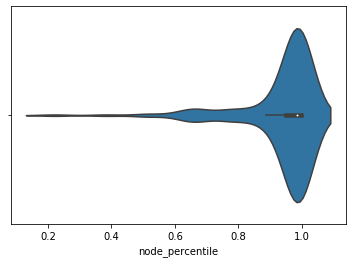

In [102]:
rank_df['node_percentile'] = ((rank_df['total'] - rank_df['rank'] + 1) / rank_df['total'])
sns.violinplot(rank_df['node_percentile']);

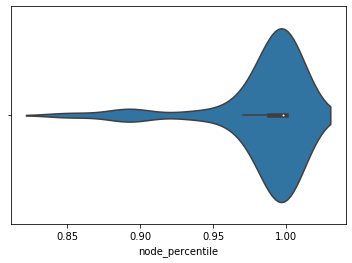

In [103]:
rank_df['node_percentile'] = ((rank_df['total'] - rank_df['rank'] + 1) / rank_df['total'])
sns.violinplot(rank_df.drop_duplicates(subset=['comp_id'])['node_percentile']);

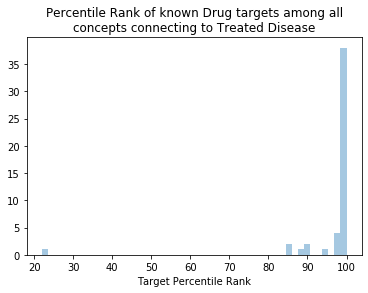

In [109]:
sns.distplot(rank_df.query('is_target').sort_values('node_percentile', ascending=False).drop_duplicates(subset=['comp_id'])['node_percentile']*100, kde=False)
plt.title('Percentile Rank of known Drug targets among all\nconcepts connecting to Treated Disease')
plt.xlabel('Target Percentile Rank');

In [105]:
rank_df.to_csv(out_dir.joinpath('node_rankings.csv'), index=False)

## Look at the highest ranked node (From a DMDB Path) for each compound-disease pair

In [106]:
best_ranks = rank_df.sort_values('rank').drop_duplicates(subset=['comp_id', 'dis_id'])
len(best_ranks)

77

In [107]:
best_ranks['is_target'].sum() / len(best_ranks)

0.8311688311688312

In [110]:
best_ranks.query('not is_target')

,rank,node_id,model_metric,node_name,node_label,total,comp_id,dis_id,is_target,comp_name,dis_name,node_percentile
0,1,GO:0019227,3.133515,neuronal action potential propagation,BiologicalProcessOrActivity,1089,CHEBI:8357,DOID:60164,False,pramocaine,Pain relief,1.000000
0,1,GO:0019227,3.200944,neuronal action potential propagation,BiologicalProcessOrActivity,513,CHEBI:8357,DOID:60145,False,pramocaine,Pain,1.000000
0,1,NCBIGene:3815,3.050373,KIT,MacromolecularMachine,8666,CHEBI:31690,DOID:349,False,imatinib methanesulfonate,systemic mastocytosis,1.000000
0,12,NCBIGene:5321,0.330432,PLA2G4A,MacromolecularMachine,5755,CHEBI:5134,DOID:6132,False,fluticasone,bronchitis,0.998089
0,13,NCBIGene:1813,0.530171,DRD2,MacromolecularMachine,7947,CHEBI:5123,DOID:5419,False,fluphenazine,schizophrenia,0.998490
0,23,GO:0008217,0.215294,regulation of blood pressure,BiologicalProcessOrActivity,6199,CHEBI:34923,DOID:10763,False,Pinacidil,hypertension,0.996451
0,23,NCBIGene:3815,0.006314,KIT,MacromolecularMachine,68,CHEBI:31690,DOID:4798,False,imatinib methanesulfonate,aggressive systemic mastocytosis,0.676471
0,33,NCBIGene:2908,0.125729,NR3C1,MacromolecularMachine,5174,CHEBI:16962,DOID:4677,False,cortisone,keratitis,0.993815
0,119,NCBIGene:5742,0.073336,PTGS1,MacromolecularMachine,14657,CHEBI:13719,DOID:60164,False,acetylsalicylate,Pain relief,0.991949
0,188,GO:0007596,0.034889,blood coagulation,BiologicalProcessOrActivity,13237,CHEBI:13719,DOID:0060903,False,acetylsalicylate,thrombosis,0.985873


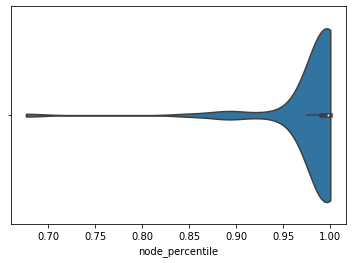

In [111]:
sns.violinplot(best_ranks['node_percentile'], cut=0);

In [112]:
len(best_ranks.drop_duplicates(subset=['comp_id']))

51

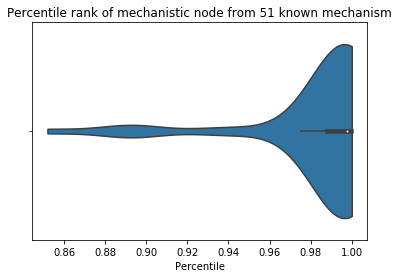

In [113]:
sns.violinplot(best_ranks.drop_duplicates(subset=['comp_id'])['node_percentile'], cut=0)
plt.title('Percentile rank of mechanistic node from 51 known mechanism')
plt.xlabel('Percentile');

In [114]:
len(best_ranks.drop_duplicates(subset=['comp_id']))

51

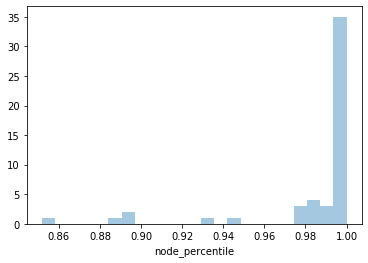

In [115]:
sns.distplot(best_ranks.drop_duplicates(subset=['comp_id'])['node_percentile'], kde=False)

In [116]:
len(best_ranks.drop_duplicates(subset=['comp_id']).query('rank <= 10'))

27

In [117]:
best_ranks.drop_duplicates(subset=['comp_id']).query('rank <= 10')

,rank,node_id,model_metric,node_name,node_label,total,comp_id,dis_id,is_target,comp_name,dis_name,node_percentile
0,1,NCBIGene:2908,0.804665,NR3C1,MacromolecularMachine,168,CHEBI:4463,DOID:70004,True,Dexamethasone acetate,Myeloma,1.000000
0,1,GO:0019227,3.133515,neuronal action potential propagation,BiologicalProcessOrActivity,1089,CHEBI:8357,DOID:60164,False,pramocaine,Pain relief,1.000000
0,1,NCBIGene:3357,2.659357,HTR2B,MacromolecularMachine,1168,CHEBI:32193,DOID:6432,True,Terguride,pulmonary hypertension,1.000000
0,1,CHEBI:27470,5.248082,folic acid,ChemicalSubstance,5709,CHEBI:15640,DOID:13382,True,5-formyltetrahydrofolic acid,megaloblastic anemia,1.000000
0,1,NCBIGene:153,7.737556,ADRB1,MacromolecularMachine,442,CHEBI:135809,DOID:0060224,True,landiolol,atrial fibrillation,1.000000
0,1,NCBIGene:79001,6.870182,VKORC1,MacromolecularMachine,4772,CHEBI:53769,DOID:9477,True,(S)-acenocoumarol,pulmonary embolism,1.000000
0,1,NCBIGene:6559,4.219812,SLC12A3,MacromolecularMachine,1749,CHEBI:64354,DOID:10763,True,metolazone,hypertension,1.000000
0,1,NCBIGene:3269,4.592025,HRH1,MacromolecularMachine,137,CHEBI:51380,DOID:4481,True,doxylamine,allergic rhinitis,1.000000
0,1,NCBIGene:367,5.778214,AR,MacromolecularMachine,1020,IKEY:HJBWBFZLDZWPHF-UHFFFAOYSA-N,DOID:10283,True,ARN509,prostate cancer,1.000000
0,1,NCBIGene:3815,3.050373,KIT,MacromolecularMachine,8666,CHEBI:31690,DOID:349,False,imatinib methanesulfonate,systemic mastocytosis,1.000000


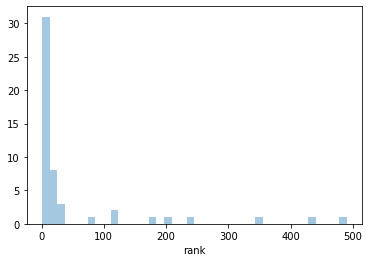

In [118]:
sns.distplot(best_ranks.drop_duplicates(subset=['comp_id'])['rank'], kde=False);

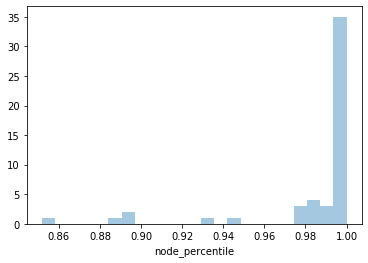

In [119]:
sns.distplot(best_ranks.drop_duplicates(subset=['comp_id'])['node_percentile'], kde=False);

In [120]:
best_ranks.query('node_percentile < .5')

,rank,node_id,model_metric,node_name,node_label,total,comp_id,dis_id,is_target,comp_name,dis_name,node_percentile


In [126]:
mapped_dmdb.query('n1 == "CHEBI:421707"')

,n1,n2,n3,n4,n5,n6,n7,n8,comp_id,dis_id
61,CHEBI:421707,missing,missing,GO:0039693,DOID:526,NaN,NaN,NaN,CHEBI:421707,DOID:526


In [127]:
mapped_dmdb.query('n1 == "CHEBI:6909"')

,n1,n2,n3,n4,n5,n6,n7,n8,comp_id,dis_id
31,CHEBI:6909,missing,GO:0003676,missing,HP:0100806,NaN,NaN,NaN,CHEBI:6909,HP:0100806
32,CHEBI:6909,missing,GO:0003676,missing,DOID:50338,NaN,NaN,NaN,CHEBI:6909,DOID:50338


In [134]:
qpe = quick_path_extract('CHEBI:421707', 'DOID:526')

100%|██████████| 89/89 [00:12<00:00,  7.32it/s]


In [135]:
qpe

,node_ids,nodes,metapath,metric,model_metric,std_metric,scal_metric
0,"[CHEBI:421707, NCBIGene:6580, GO:1901374, CHEB...","[abacavir, SLC22A1, acetate ester transport, v...",CafGpoBPpoCtD,4.383151e-07,4.891538e-01,3.111831e-02,0.211909
1,"[CHEBI:421707, NCBIGene:6580, KEGG:hsa05231, D...","[abacavir, SLC22A1, Choline metabolism in canc...",CinGpoPWawD,5.313144e-07,9.790735e-02,5.016662e-03,0.067547
2,"[CHEBI:421707, NCBIGene:6580, REACT:R-HSA-1123...","[abacavir, SLC22A1, Transmission across Chemic...",CinGpoPWawD,2.481769e-07,4.573251e-02,1.671798e-03,0.031551
3,"[CHEBI:421707, NCBIGene:6580, REACT:R-HSA-1123...","[abacavir, SLC22A1, Neuronal System, human imm...",CinGpoPWawD,1.809775e-07,3.334942e-02,1.024339e-03,0.023008
4,"[CHEBI:421707, NCBIGene:6580, REACT:R-HSA-1430...","[abacavir, SLC22A1, Metabolism, human immunode...",CinGpoPWawD,3.459216e-08,6.374431e-03,5.279860e-05,0.004398
...,...,...,...,...,...,...,...
222763,"[CHEBI:421707, NCBIGene:9429, GO:0005634, NCBI...","[abacavir, ABCG2, cell nucleus, TRIM5, human i...",CinGpoApoGtD,3.281395e-08,2.702919e-07,8.447687e-09,0.029554
222764,"[CHEBI:421707, NCBIGene:9429, GO:0005829, NCBI...","[abacavir, ABCG2, cytosol, SERPINA1, human imm...",CinGpoApoGtD,1.576697e-08,1.298742e-07,2.865777e-09,0.014201
222765,"[CHEBI:421707, NCBIGene:9429, GO:0005829, NCBI...","[abacavir, ABCG2, cytosol, TRIM5, human immuno...",CinGpoApoGtD,2.084128e-08,1.716718e-07,4.378961e-09,0.018771
222766,"[CHEBI:421707, NCBIGene:9429, GO:0005886, NCBI...","[abacavir, ABCG2, plasma membrane, SERPINA1, h...",CinGpoApoGtD,2.061833e-08,1.698354e-07,4.309310e-09,0.018570


In [136]:
rank_connecting_nodes(qpe).query('node_id == "GO:0039693"')

,node_id,model_metric,node_name,node_label


In [137]:
path_res[('CHEBI:6909', 'DOID:50338')]

KeyError: ('CHEBI:6909', 'DOID:50338')

## Look at target information only

In [138]:
n_sum_df

,comp_id,dis_id,comp_name,dis_name,target_id,target_name,tgt_rank,total_tgt
0,CHEBI:31690,DOID:8552,imatinib methanesulfonate,chronic myeloid leukemia,NCBIGene:25,ABL1,5.0,540.0
1,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:3815,KIT,11.0,45.0
2,CHEBI:31690,DOID:4660,imatinib methanesulfonate,indolent systemic mastocytosis,NCBIGene:3815,KIT,NaN,2.0
3,CHEBI:31690,DOID:349,imatinib methanesulfonate,systemic mastocytosis,NCBIGene:3815,KIT,1.0,540.0
4,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:5156,PDGFRA,16.0,45.0
...,...,...,...,...,...,...,...,...
103,CHEBI:74789,DOID:9060,9-aminoacridine,pityriasis versicolor,DOID:9060,pityriasis versicolor,NaN,6.0
104,CHEBI:4637,DOID:9060,diphenhydramine hydrochloride,pityriasis versicolor,DOID:9060,pityriasis versicolor,NaN,9.0
105,CHEBI:135990,DOID:1470,gepirone,major depressive disorder,NCBIGene:3350,HTR1A,1.0,2.0
106,CHEBI:8598,DOID:1470,protriptyline hydrochloride,major depressive disorder,NCBIGene:6530,SLC6A2,11.0,16.0


In [139]:
n_sum_df['tgt_pctile'] = ((n_sum_df['total_tgt'] - n_sum_df['tgt_rank'] + 1 ) / n_sum_df['total_tgt'])

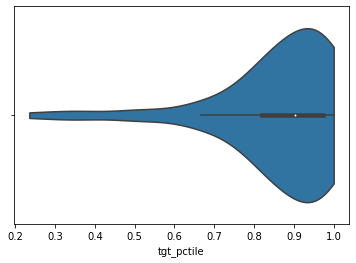

In [140]:
sns.violinplot(n_sum_df['tgt_pctile'], cut=0);

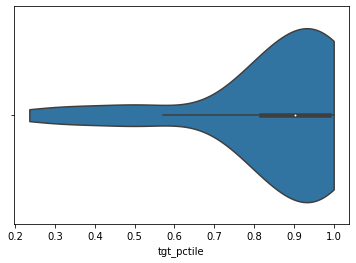

In [141]:
sns.violinplot(n_sum_df.drop_duplicates(subset=['comp_id'])['tgt_pctile'], cut=0);

In [142]:
n_sum_df.to_csv(out_dir.joinpath('target_summary.csv'), index=False)

## Look at the low ranking targets to see how other pathmembers faired

In [143]:
n_sum_df.query('tgt_pctile < .8')

,comp_id,dis_id,comp_name,dis_name,target_id,target_name,tgt_rank,total_tgt,tgt_pctile
1,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:3815,KIT,11.0,45.0,0.777778
4,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:5156,PDGFRA,16.0,45.0,0.666667
15,CHEBI:13719,DOID:0060903,acetylsalicylate,thrombosis,NCBIGene:5742,PTGS1,247.0,1144.0,0.784965
16,CHEBI:13719,DOID:0060903,acetylsalicylate,thrombosis,NCBIGene:5742,PTGS1,247.0,1144.0,0.784965
27,CHEBI:41879,DOID:970,dexamethasone,tenosynovitis,NCBIGene:2908,NR3C1,3177.0,4155.0,0.235620
29,CHEBI:84115,DOID:4730,antazoline,vasomotor rhinitis,NCBIGene:3269,HRH1,2.0,2.0,0.500000
30,CHEBI:7731,DOID:11400,ofloxacin,pyelonephritis,NCBIGene:7153,TOP2A,153.0,354.0,0.570621
31,CHEBI:6741,DOID:60164,meloxicam,Pain relief,NCBIGene:5743,PTGS2,29.0,113.0,0.752212
41,CHEBI:3398,DOID:11204,carbinoxamine,allergic conjunctivitis,NCBIGene:3269,HRH1,2.0,3.0,0.666667
55,CHEBI:8378,DOID:11335,prednisolone,sarcoidosis,NCBIGene:2908,NR3C1,185.0,370.0,0.502703


In [144]:
low_rank_tgts = []

for row in n_sum_df.query('tgt_pctile < .8').itertuples():
    cid = row.comp_id
    did = row.dis_id
    
    low_rank_tgts.append(rank_df.query('comp_id == @cid and dis_id == @did'))
    
low_rank_tgts = pd.concat(low_rank_tgts, sort=False).drop_duplicates()
low_rank_tgts[['comp_id', 'dis_id', 'comp_name', 'dis_name', 'node_id', 'node_label',
               'is_target', 'node_name', 'rank', 'total', 'node_percentile']]

,comp_id,dis_id,comp_name,dis_name,node_id,node_label,is_target,node_name,rank,total,node_percentile
0,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:3815,MacromolecularMachine,True,KIT,23,68,0.676471
1,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,GO:0008283,BiologicalProcessOrActivity,False,cellular proliferation,27,68,0.617647
2,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:5156,MacromolecularMachine,False,PDGFRA,34,68,0.514706
0,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:3815,MacromolecularMachine,False,KIT,23,68,0.676471
2,CHEBI:31690,DOID:4798,imatinib methanesulfonate,aggressive systemic mastocytosis,NCBIGene:5156,MacromolecularMachine,True,PDGFRA,34,68,0.514706
0,CHEBI:13719,DOID:0060903,acetylsalicylate,thrombosis,GO:0007596,BiologicalProcessOrActivity,False,blood coagulation,188,13237,0.985873
1,CHEBI:13719,DOID:0060903,acetylsalicylate,thrombosis,NCBIGene:5742,MacromolecularMachine,True,PTGS1,445,13237,0.966458
2,CHEBI:13719,DOID:0060903,acetylsalicylate,thrombosis,CHEBI:15627,ChemicalSubstance,False,thromboxane A2,3071,13237,0.768074
0,CHEBI:41879,DOID:970,dexamethasone,tenosynovitis,GO:0006954,BiologicalProcessOrActivity,False,inflammatory response,234,4431,0.947416
1,CHEBI:41879,DOID:970,dexamethasone,tenosynovitis,NCBIGene:301,MacromolecularMachine,False,ANXA1,2735,4431,0.382984
